<a href="https://colab.research.google.com/github/victormurcia/VCHAMPS/blob/main/VCHAMPS_Data_Engineering_VMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#General utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
import seaborn as sns
from tqdm import tqdm  # Import tqdm for the progress bar
import glob,shutil,os,warnings,math,time,sys,re
from typing import List
import dask.dataframe as dd

#For converting states to their abbreviations
!pip install us
import us

#For performing UTC normalization on datetime columns based on the STATE column
import pytz

#For Slider viz
import ipywidgets as widgets
from IPython.display import display, clear_output,HTML

#For EDA
#!pip install dataprep
#from dataprep.eda import create_report

#Enable data to be extracted and downloaded from my Google Drive
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Specify the path to the desired directory
directory_path = r'/content/drive/MyDrive/Train_Data_Parquet.zip (Unzipped Files)'

# Change the current working directory to the desired directory
os.chdir(directory_path)

# Verify the current working directory
current_directory = os.getcwd()


print(f"Current working directory: {current_directory}")

Current working directory: /content/drive/MyDrive/Train_Data_Parquet.zip (Unzipped Files)


## Working with Training Data
Now that the data has been converted I'm going to start going through the task list. As a form of a checksum, I've computed the number of partitions that each .csv split to after the parquet conversion.

In [3]:
print('The CWD is: ',current_directory)
#Get a list of directories in CWD that deal with parquet files
parquet_directories = [directory for directory in os.listdir(current_directory) if os.path.isdir(os.path.join(current_directory, directory)) and directory.endswith('.parquet')]

# Create an empty DataFrame to store the results
parquet_files_list = []

# Iterate over the parquet_directories and populate the DataFrame
for i, parquet in enumerate(parquet_directories):
    num_parquet_files = len(glob.glob(parquet + '/*.parquet'))
    parquet_files_list.append({'Directory': parquet, 'Num Partitions': num_parquet_files})

    # Create a DataFrame from the results list using pandas.concat
parquet_files_df = pd.concat([pd.DataFrame(r, index=[0]) for r in parquet_files_list], ignore_index=True)
parquet_files_df

The CWD is:  /content/drive/MyDrive/Train_Data_Parquet.zip (Unzipped Files)


,Directory,Num Partitions
0,conditions_train.parquet,161
1,demographics_event_train.parquet,1
2,demographics_static_train.parquet,1
3,death_train.parquet,1
4,ed_visits_train.parquet,1
5,immunization_train.parquet,3
6,inpatient_admissions_train.parquet,2
7,inpatient_location_train.parquet,1
8,inpatient_specialty_train.parquet,2
9,measurements_train.parquet,164


In [4]:
# Find directories that end with .parquet
parquet_directories = [directory for directory in os.listdir(current_directory) if os.path.isdir(os.path.join(current_directory, directory)) and directory.endswith('.parquet')]

#Initiate slider var
val = 0

# Create a slider widget to control the value of val
slider = widgets.IntSlider(
    min=0,
    max=len(parquet_directories) - 1,
    step=1,
    description='Select Value:',
    value=val,
    layout={'width': '400px'}
)

# Create an output widget to display the DataFrame
output = widgets.Output()

# Function to update the Dask DataFrame based on the selected value
def update_dataframe(value):
    global val
    val = value  # Update the value of val
    parquet_directory = parquet_directories[val]
    df = dd.read_parquet(f'{parquet_directory}/*.parquet')
    file_name = parquet_directory.split('/')[-1]

    with output:
        clear_output(wait=True)
        print("File Name:", file_name)
        print("Number of rows:", len(df))
        print("Number of columns:", len(df.columns))
        display(df.head(10))

# Call the update_dataframe function to initialize the Dask DataFrame
update_dataframe(val)

# Create an observer for the slider widget
def slider_observer(change):
    update_dataframe(change.new)

# Add the observer to the slider widget
slider.observe(slider_observer, names='value')

# Display the slider widget and the output widget
display(slider)
display(output)

IntSlider(value=0, description='Select Value:', layout=Layout(width='400px'), max=15)

Output()

# Convert Dates from Object to Datetime Data Types
The dates (and most other attributes) in this dataset are all saved as objects which consume a lot of memory. I'm going to convert all the dates into datetime objects before continuing since not only it will save memory and improve computation speed, but it will also facilitate operations with time data. This can lead to memory decreases of approximately 50%.

In [5]:
def convert_date_columns(dataframes):
    for df in dataframes:
        # Find columns with 'date' in the name excluding 'Age at update'
        date_columns = [col for col in df.columns if 'date' in col.lower() and col != 'Age at update']

        # Convert date columns to datetime
        for col in date_columns:
            df[col] = dd.to_datetime(df[col], errors='coerce')

# Find directories that end with .parquet
parquet_directories = [directory for directory in os.listdir(current_directory) if os.path.isdir(os.path.join(current_directory, directory)) and directory.endswith('.parquet')]

# Create an empty list to store the dataframes
dataframes = []

for directory in parquet_directories:
    df = dd.read_parquet(f'{directory}/*.parquet')
    dataframes.append(df)

# list of Dask dataframes
convert_date_columns(dataframes)

Cool! That worked.

## Convert Ages from Float64 to Int8
Now I'm going to convert all the age columns to integers by rounding. I'll convert them to int8 since it consumes a lot less memory and we don't need anything bigger than that since int8 can represent values between -128 to 127. There is no age larger than 120 in this dataset. This can reduce memory usage by approximately 13%

In [6]:
def convert_age_columns(dataframes):
    for df in dataframes:
        # Find columns with 'age' in the name excluding 'Agentorangeflag'
        age_columns = [col for col in df.columns if 'age' in col.lower() and col != 'Agentorangeflag']

        # Convert age columns to float64 and round
        for col in age_columns:
            df[col] = df[col].astype('float64').round().astype('int8')

convert_age_columns(dataframes)

# Convert State Names to their Abbreviated Forms
One more thing that I can do to save memory and expedite future calculations/transformations is convert state names to their abbreviated forms. This can result in approximately 30% memory usage.

In [7]:
def convert_state_columns(dataframes):
    for df in dataframes:
        if 'State' in df.columns:
            df['State'] = df['State'].apply(convert_state_name, meta=('State', 'object'))

def convert_state_name(state_name):
    try:
        return us.states.lookup(state_name).abbr
    except AttributeError:
        return state_name
convert_state_columns(dataframes)

# Converting InternalpatientId to a lower int Representation
The last immediate opportunity for memory usage optimization could be made by converting the InternalpatientId columns from int64 to something lower. The first thing I need to find is the maximum value of InternalpatientId. My guess is that the lowest I'll be able to go is int32 since that ranges between -2,147,483,648 to 2,147,483,647. I don't think int16 will be possible since that ranges from -32,768 to 32,767 and we definitely have more patients than that on the dataset.

In [8]:
df = dd.read_parquet(f'{parquet_directories[0]}/*.parquet')
print('Number of unique patient IDs: ',df['Internalpatientid'].nunique().compute())
print('Smallest Patient ID: ',df['Internalpatientid'].min().compute())
print('Largest Patient ID: ',df['Internalpatientid'].max().compute())

Number of unique patient IDs:  133252
Smallest Patient ID:  1
Largest Patient ID:  169064


Okay, int32 is the smallest int type I can use, so I'll go ahead and convert that.

In [9]:
def convert_internalpatientid_columns(dataframes):
    for df in dataframes:
        # Check if 'Internalpatientid' column exists
        if 'Internalpatientid' in df.columns:
            # Convert 'Internalpatientid' column to int32
            df['Internalpatientid'] = df['Internalpatientid'].astype('int32')

# Usage example:
convert_internalpatientid_columns(dataframes)

# Add Visit End Date to Outpatient Visits
This dataframe only provides a Visit Start Date. In order to have a range, I'll incorporate a Visit End Date column that will be equal to Visit Start Date +2 hours.

In [10]:
# Add 'Visit End Date' to the dataframe
dataframes[15]['Visit End Date'] = dataframes[15]['Visit start date'] + pd.Timedelta(hours=2)

# Get a list of all the column names
columns = dataframes[15].columns.tolist()

# Make sure 'Visit End Date' is in the list of columns and remove it
if 'Visit End Date' in columns:
    columns.remove('Visit End Date')

# Find the index of 'Visit start date' column
index = columns.index('Visit start date')

# Insert 'Visit End Date' right after 'Visit start date'
columns.insert(index + 1, 'Visit End Date')

# Reorder the columns in the DataFrame
dataframes[15] = dataframes[15][columns]

In [11]:
dataframes[15].columns

Index(['Internalpatientid', 'Age at visit', 'Visit start date',
       'Visit End Date', 'First listed diagnosis icd10 subcategory',
       'Second listed diagnosis icd10 subcategory', 'Stop code',
       'Agentorangeflag', 'Combatflag', 'Ionizingradiationflag',
       'Serviceconnectedflag', 'Swasiaconditionsflag', 'State'],
      dtype='object')

# Normalize DateTimes to UTC


In [ ]:
state_timezone_mapping = {
    'Alabama': 'America/Chicago',
    'Alaska': 'America/Anchorage',
    'Arizona': 'America/Phoenix',
    'Arkansas': 'America/Chicago',
    'California': 'America/Los_Angeles',
    'Colorado': 'America/Denver',
    'Connecticut': 'America/New_York',
    'Delaware': 'America/New_York',
    'Florida': 'America/New_York',
    'Georgia': 'America/New_York',
    'Hawaii': 'Pacific/Honolulu',
    'Idaho': 'America/Boise',
    'Illinois': 'America/Chicago',
    'Indiana': 'America/Indiana/Indianapolis',
    'Iowa': 'America/Chicago',
    'Kansas': 'America/Chicago',
    'Kentucky': 'America/New_York',
    'Louisiana': 'America/Chicago',
    'Maine': 'America/New_York',
    'Maryland': 'America/New_York',
    'Massachusetts': 'America/New_York',
    'Michigan': 'America/Detroit',
    'Minnesota': 'America/Chicago',
    'Mississippi': 'America/Chicago',
    'Missouri': 'America/Chicago',
    'Montana': 'America/Denver',
    'Nebraska': 'America/Chicago',
    'Nevada': 'America/Los_Angeles',
    'New Hampshire': 'America/New_York',
    'New Jersey': 'America/New_York',
    'New Mexico': 'America/Denver',
    'New York': 'America/New_York',
    'North Carolina': 'America/New_York',
    'North Dakota': 'America/Chicago',
    'Ohio': 'America/New_York',
    'Oklahoma': 'America/Chicago',
    'Oregon': 'America/Los_Angeles',
    'Pennsylvania': 'America/New_York',
    'Rhode Island': 'America/New_York',
    'South Carolina': 'America/New_York',
    'South Dakota': 'America/Chicago',
    'Tennessee': 'America/Chicago',
    'Texas': 'America/Chicago',
    'Utah': 'America/Denver',
    'Vermont': 'America/New_York',
    'Virginia': 'America/New_York',
    'Washington': 'America/Los_Angeles',
    'West Virginia': 'America/New_York',
    'Wisconsin': 'America/Chicago',
    'Wyoming': 'America/Denver'
}

def convert_date_columns(dataframes):
    """
    Convert date columns in DataFrame(s) to UTC based on the respective state's timezone.

    Parameters:
        dataframes (list): List of DataFrames to process.

    Returns:
        None

    Raises:
        None
    """
    for df in tqdm(dataframes, desc='Processing DataFrames', unit='DataFrame'):
        if 'State' in df.columns:
            # Find columns with 'date' in the name excluding 'Age at update'
            date_columns = [col for col in df.columns if 'date' in col.lower() and col != 'Age at update']

            # Convert date columns to datetime based on state timezone
            for col in date_columns:
                print(f" Processing column: {col}")
                for state_name in df['State']:
                    timezone = state_timezone_mapping.get(state_name)
                    if timezone is not None:
                        timezone = pytz.timezone(timezone)
                        df[col] = df[col].dt.tz_localize(timezone).dt.tz_convert('UTC')
        else:
            print('No State column found in current dataframe')

# list of Dask dataframes
convert_date_columns(dataframes)

# Remove State Columns
Since all the datetimes are in UTC now, the State columns are unnecessary so I'll remove them from the dataframes.

In [12]:
def drop_state_column(dataframes):
    """
    Drop the 'State' column from each Dask DataFrame in the given list, if it exists.

    Parameters:
        dataframes (list): List of Dask DataFrames.

    Returns:
        list: List of updated Dask DataFrames.

    Raises:
        None
    """
    updated_dataframes = []

    for df in dataframes:
        if 'State' in df.columns:
            df = df.drop(columns='State')
        updated_dataframes.append(df)

    return updated_dataframes

updated_dataframes = drop_state_column(dataframes)

In [29]:
updated_dataframes[4].columns

Index(['Internalpatientid', 'Age at ed visit', 'Ed visit start date',
       'Discharge date ed', 'Died during ed visit',
       'First listed diagnosis icd10 subcategory',
       'Second listed diagnosis icd10 subcategory'],
      dtype='object')

# Convert some Attributes to Categorical Datatypes

Doing this can save memory and make some operations more efficient.

In [ ]:
# Convert 'Category' column to categorical data type
df['Category'] = df['Category'].categorize()

In [25]:
parquet_directories[10:]

['lab_results_train.parquet',
 'measurements_blood_pressure_train.parquet',
 'medications_administered_train.parquet',
 'medications_ordered_train.parquet',
 'procedures_train.parquet',
 'outpatient_visits_train.parquet']

In [28]:
# Save each DataFrame as Parquet files
for i, df in enumerate(updated_dataframes[10:]):
     # Save the path for the Parquet file
    save_path = f'/content/drive/MyDrive/VCHAMPS - Train Data -  UTC/{parquet_directories[10:][i]}'
    print(save_path)
    #df_computed = df.compute()  # Compute the Dask DataFrame
    df.to_parquet(save_path)

/content/drive/MyDrive/VCHAMPS - Train Data -  UTC/lab_results_train.parquet
/content/drive/MyDrive/VCHAMPS - Train Data -  UTC/measurements_blood_pressure_train.parquet
/content/drive/MyDrive/VCHAMPS - Train Data -  UTC/medications_administered_train.parquet
/content/drive/MyDrive/VCHAMPS - Train Data -  UTC/medications_ordered_train.parquet
/content/drive/MyDrive/VCHAMPS - Train Data -  UTC/procedures_train.parquet
/content/drive/MyDrive/VCHAMPS - Train Data -  UTC/outpatient_visits_train.parquet


# Constructing CV Diagnosis Variable
This variable will be constructed by looking at the inpatient_admissions and checking for matches in either the first or second listed diagnoses columns based on the ivd10 subcategories listed below (provided by Jeff).

To Do:

Construct the mortality outcome variables based on the mapping of encounters and hospitalizations

In [12]:
diagnosis_list = [
    "Systolic (congestive) heart failure",
    "Diastolic (congestive) heart failure",
    "Heart failure (unspecified)",
    "Other heart failure",
    "Combined systolic (congestive) and diastolic (congestive) heart failure",
    "Cardiogenic shock",
    "Hypertensive heart disease with heart failure",
    "Hypertensive heart and kidney disease with heart failure",
    "ST elevation (STEMI) myocardial infarction",
    "Non-ST elevation (NSTEMI) myocardial infarction",
    "Unstable angina",
    "Other forms of chronic ischemic heart disease",
    "Atherosclerotic heart disease of native coronary artery",
    "Atrial fibrillation",
    "Atrial flutter",
    "Supraventricular tachycardia",
    "Ventricular tachycardia"
]

#Get the CV from each column
df1 = dataframes[4]
df2 = dataframes[6]
df3 = dataframes[15]
df1["CV diagnosis"] = df1.apply(lambda row: 1 if row["First listed diagnosis icd10 subcategory"] in diagnosis_list or row["Second listed diagnosis icd10 subcategory"] in diagnosis_list else 0, axis=1, meta=('CV diagnosis', 'int8'))
df2["CV diagnosis"] = df2.apply(lambda row: 1 if row["First listed discharge diagnosis icd10 subcategory"] in diagnosis_list or row["Second listed discharge diagnosis icd10 subcategory"] in diagnosis_list else 0, axis=1, meta=('CV diagnosis', 'int8'))
df3["CV diagnosis"] = df3.apply(lambda row: 1 if row["First listed diagnosis icd10 subcategory"] in diagnosis_list or row["Second listed diagnosis icd10 subcategory"] in diagnosis_list else 0, axis=1, meta=('CV diagnosis', 'int8'))

# Specify the expected metadata
meta = ('object', 'object')

#Drop the diagnosis columns because they consume a crapton of memory
#df1 = df1.drop(columns=['First listed diagnosis icd10 subcategory', 'Second listed diagnosis icd10 subcategory'])
#df2 = df2.drop(columns=['First listed discharge diagnosis icd10 subcategory', 'Second listed discharge diagnosis icd10 subcategory'])
#df3 = df3.drop(columns=['First listed diagnosis icd10 subcategory', 'Second listed diagnosis icd10 subcategory'])

#Place the converted dataframes back into the list
#dataframes[4]  = df1
#dataframes[6]  = df2
#dataframes[15] = df3

Let's check if that worked.

We found results for all of the listed CV conditions. It appears to be working well. Now let's look at the distribution of CV diagnosis

Hmmm, about 20% of the patients had a positive CV diagnosis. Great, below is a widget that shows the datatypes after applying these conversions.

In [13]:
# Create an index slider
index_slider = widgets.IntSlider(min=0, max=len(dataframes)-1, value=0, description='DataFrame Index')

# Function to display the data types of columns
def display_data_types(index):
    df = dataframes[index]
    data_types = df.dtypes
    with out:
        clear_output(wait=True)
        display(data_types)

# Display the initial data types
out = widgets.Output()
display(out)
display_data_types(index_slider.value)

# Link the slider value to the display_data_types function
index_slider.observe(lambda change: display_data_types(change.new), names='value')

# Display the slider
display(index_slider)

Output()

IntSlider(value=0, description='DataFrame Index', max=15)

Finally, here is a visualizer for the transformed columns.

In [14]:
#Initiate slider var
val = 0

# Create a slider widget to control the value of val
slider = widgets.IntSlider(
    min=0,
    max=len(parquet_directories) - 1,
    step=1,
    description='Select Value:',
    value=val,
    layout={'width': '400px'}
)

# Create an output widget to display the DataFrame
output = widgets.Output()

# Function to update the Dask DataFrame based on the selected value
def update_dataframe(value):

    global val

    val = value  # Update the value of val
    df = dataframes[val]
    parquet_directory = parquet_directories[val]
    file_name = parquet_directory.split('/')[-1]

    with output:
        clear_output(wait=True)
        print("File Name:", file_name)
        #print("Number of rows:", len(df))
        #print("Number of columns:", len(df.columns))
        display(df.head(10))

# Call the update_dataframe function to initialize the Dask DataFrame
update_dataframe(val)

# Create an observer for the slider widget
def slider_observer(change):
    update_dataframe(change.new)

# Add the observer to the slider widget
slider.observe(slider_observer, names='value')

# Display the slider widget and the output widget
display(slider)
display(output)

IntSlider(value=0, description='Select Value:', layout=Layout(width='400px'), max=15)

Output()

# Get Unique Counts for Massive Dataframes


In [17]:
# Set display options to show all rows
pd.set_option('display.max_rows', 10)

# Get unique values and their counts from 'Column 1'
value_counts = dataframes[0]['Condition code icd10 subcategory'].value_counts()

# Convert the result into a Dask DataFrame
conditions_freq = value_counts.reset_index().compute()

# Save DataFrame as CSV
conditions_freq.to_csv('conditions_freq.csv', index=False)

conditions_freq

In [18]:
conditions_freq

,index,Condition code icd10 subcategory
0,Essential (primary) hypertension,4327964
1,Type 2 diabetes mellitus without complications,2956322
2,Encounter for other specified aftercare,2540325
3,Not specified,2240715
4,Other specified counseling,1979166
...,...,...
8831,Fracture of clavicle due to birth injury,1
8832,Unspecified car occupant injured in collision ...,1
8833,Scombroid fish poisoning,1
8834,Seborrheic dermatitis,1


In [24]:
dataframes[9].columns

Index(['Internalpatientid', 'Age at measurement', 'Measurement date',
       'Measurement', 'Result numeric', 'Result textual', 'State'],
      dtype='object')

In [25]:
# Get unique values and their counts from 'Column 1'
value_counts = dataframes[9]['Measurement'].value_counts()

# Convert the result into a Dask DataFrame
measurements_df = value_counts.reset_index().compute()

# Save DataFrame as CSV
measurements_df.to_csv('measurements_freq.csv', index=False)

measurements_df

,index,Measurement
0,Pain,23633224
1,Blood pressure,22601676
2,Pulse,21684496
3,Respiratory rate,17678169
4,Temperature,17215399
5,Pulse oximetry,11441793
6,Weight,7907380
7,Height,2999240
8,Circumference/girth,53019
9,Central venous pressure,32766


In [26]:
dataframes[10].columns

Index(['Internalpatientid', 'Age at lab test', 'Lab test date', 'Lab test',
       'Lab test description', 'Result numeric', 'Result textual',
       'Result range', 'Result units', 'Specimen source', 'State'],
      dtype='object')

In [15]:
# Sample 10% of the rows from the DataFrame
sampled_rows = dataframes[10]['Lab test'].sample(frac=0.1)

# Get unique values and their counts from 'Column 1'
value_counts = sampled_rows.value_counts()

# Convert the result into a Dask DataFrame
lab_test_df = value_counts.reset_index().compute()

# Save DataFrame as CSV
lab_test_df.to_csv('Lab_Test_freq.csv', index=False)

lab_test_df

,index,Lab test
0,glucose_mg/dl_plasma,289931
1,hct_%_blood,282985
2,calcium_mg/dl_plasma,232654
3,hgb_g/dl_blood,221052
4,mcv_fl_no specimen,219761
...,...,...
91795,"pth,mineral metab(yale)_null_serum",1
91796,cyclic citrulline peptide (d/c 1/2020)_u_serum,1
91797,cyclic citrulline peptide igg_units_serum,1
91798,cyclic citrulline peptide(igg)(dc'd)_u_no spec...,1


In [19]:
dataframes[12].columns

Index(['Internalpatientid', 'Age at med administration', 'Administration date',
       'Administration end date', 'Administered medication atc 5',
       'Administration status', 'Dose form', 'Dose administered',
       'Dose unit administered', 'State'],
      dtype='object')

In [22]:
# Sample 10% of the rows from the DataFrame
sampled_rows = dataframes[12]['Administered medication atc 5'].sample(frac=0.1)

# Get unique values and their counts from 'Column 1'
value_counts = sampled_rows.value_counts()

# Convert the result into a Dask DataFrame
medication_admin_atc_df = value_counts.reset_index().compute()

# Save DataFrame as CSV
medication_admin_atc_df.to_csv('medication_admin_atc.csv', index=False)

medication_admin_atc_df

,index,Administered medication atc 5
0,Not specified,759906
1,metoprolol,360249
2,docusate,317541
3,salbutamol,279804
4,furosemide,260712
...,...,...
2279,glyceryl trinitrate ; soft paraffin and fat pr...,1
2280,dolutegravir ; lamivudine,1
2281,"docusate sodium, including combinations",1
2282,cabozantinib,1


In [20]:
dataframes[13].columns

Index(['Internalpatientid', 'Age at med ordered', 'Order date',
       'Medication start date', 'Medication stop date',
       'Order discontinue date', 'Ordered medication atc 5', 'Order status',
       'Stop reason', 'State'],
      dtype='object')

In [23]:
# Sample 10% of the rows from the DataFrame
sampled_rows = dataframes[13]['Ordered medication atc 5'].sample(frac=0.1)

# Get unique values and their counts from 'Column 1'
value_counts = sampled_rows.value_counts()

# Convert the result into a Dask DataFrame
medication_order_atc_df = value_counts.reset_index().compute()

# Save DataFrame as CSV
medication_order_atc_df.to_csv('medication_order_atc.csv', index=False)

medication_order_atc_df

,index,Ordered medication atc 5
0,Not specified,419538
1,furosemide,168832
2,metoprolol,137460
3,lisinopril,130125
4,Not a medication,122640
...,...,...
3260,aminogluthetimide,1
3261,iopanoic acid,1
3262,naldemedine,1
3263,protirelin,1


In [24]:
# Sample 10% of the rows from the DataFrame
sampled_rows = dataframes[13]['Order status'].sample(frac=0.1)

# Get unique values and their counts from 'Column 1'
value_counts = sampled_rows.value_counts()

# Convert the result into a Dask DataFrame
order_status_df = value_counts.reset_index().compute()

# Save DataFrame as CSV
order_status_df.to_csv('order_status.csv', index=False)

order_status_df

,index,Order status
0,discontinued,3464298
1,expired,1420177
2,discontinued/edit,631201
3,cancelled,216424
4,complete,99816
...,...,...
7,unreleased,824
8,hold,512
9,pending,463
10,delayed,133


In [25]:
# Sample 10% of the rows from the DataFrame
sampled_rows = dataframes[13]['Stop reason'].sample(frac=0.1)

# Get unique values and their counts from 'Column 1'
value_counts = sampled_rows.value_counts()

# Convert the result into a Dask DataFrame
stop_resason_df = value_counts.reset_index().compute()

# Save DataFrame as CSV
stop_resason_df.to_csv('stop_resason.csv', index=False)

order_status_df

,index,Order status
0,discontinued,3464298
1,expired,1420177
2,discontinued/edit,631201
3,cancelled,216424
4,complete,99816
...,...,...
7,unreleased,824
8,hold,512
9,pending,463
10,delayed,133


In [21]:
dataframes[14].columns

Index(['Internalpatientid', 'Age at procedure', 'Procedure date',
       'Procedure code', 'Procedure code description', 'State'],
      dtype='object')

In [26]:
# Sample 10% of the rows from the DataFrame
sampled_rows = dataframes[14]['Procedure code'].sample(frac=0.1)

# Get unique values and their counts from 'Column 1'
value_counts = sampled_rows.value_counts()

# Convert the result into a Dask DataFrame
proc_code_df = value_counts.reset_index().compute()

# Save DataFrame as CSV
proc_code_df.to_csv('proc_code.csv', index=False)

proc_code_df

,index,Procedure code
0,99211,341776
1,99213,323133
2,98966,304095
3,85025,235981
4,85610,216896
...,...,...
16459,0DB64Z3,1
16460,0DB64ZZ,1
16461,0DB68ZZ,1
16462,0DB74ZX,1


In [27]:
# Sample 10% of the rows from the DataFrame
sampled_rows = dataframes[14]['Procedure code description'].sample(frac=0.1)

# Get unique values and their counts from 'Column 1'
value_counts = sampled_rows.value_counts()

# Convert the result into a Dask DataFrame
proc_code_desc_df = value_counts.reset_index().compute()

# Save DataFrame as CSV
proc_code_desc_df.to_csv('proc_code_desc.csv', index=False)

proc_code_desc_df

,index,Procedure code description
0,OFFICE OR OTHER OUTPATIENT VISIT FOR THE EVALU...,340768
1,OFFICE OR OTHER OUTPATIENT VISIT FOR THE EVALU...,322503
2,TELEPHONE ASSESSMENT AND MANAGEMENT SERVICE PR...,303610
3,"BLOOD COUNT; COMPLETE (CBC), AUTOMATED (HGB, H...",235731
4,PROTHROMBIN TIME;,216612
...,...,...
16374,"Measurement of Venous Saturation, Peripheral, ...",1
16375,"Measurement of Venous Saturation, Peripheral, ...",1
16376,"Measurement of Venous Pressure, Portal, Percut...",1
16377,"Measurement of Venous Pressure, Peripheral, Ex...",1


# Notes for Future Work
We also need to figure out what attributes we can/want to remove/drop from our analysis. The dataset is large enough that dropping NaNs is likely an okay strategy instead of imputation.

*   conditions_train
 *  Condition Type will be one hot encoded - 2 categories
 * Diagnosis Sequence could be one hot encoded - 27 categories
 * What to do about state? Maybe group into East, West, and Mid? - 51 categories
*   demographics_event_train
 * Marital Status will be one hot encoded - 8 categories
 * RUCA category will be one hot encoded - 4 categories
* demographics_static_train
 * Ethnicity will be one hot encoded - 3 categories
 * Gender will be one hot encoded - 2 categories
 * Races could be one hot encoded - 15 categories
 * Veteran Flag will be one hot encoded - 2 categories
* ed_visits_train
 * Died during ed visit will be one hot encoded - 2 categories
* immunization_train
 * What do we want to do with this data?
* inpatient_admissions_train
 *
* inpatient_location_train
 *



## Get number of unique patients
Number of unique patient determined by extracting patient IDs and placing them into a set. There are a total of **133252** unique patients in this dataset. This seems to be well within the range of 160-170K of the total patients that make up this dataset. The remaining patients must be in the test dataset.

In [15]:
#PIDs = []
#for directory in parquet_directories:
    #df = dd.read_parquet(f'{parquet_directories[val]}/*.parquet')
#    df = dd.read_parquet(f'{directory}/*.parquet')
#    pid = df['Internalpatientid'].unique().compute().tolist()
#    PIDs.extend(pid)
#PIDs_unique = list(set(PIDs))
#print('There are ' + str(len(PIDs_unique)) + ' unique patients in this dataset.')

## Find number of encounters
An encounter is defined by a location (inpatient, ED, clinic visit), start date, and an end date. They are also associated with a patient ID.

For things like procedures, labs, measurements, etc., they will be given an encounter ID based on what date they took place.

Note:
So, if a procedure, lab, measurement is documented to occur outside of the range of an encounter ID (this should ideally not happen), then I'm guessing the encounter ID is ... null?

Need to look at:
* ed_visits
* inpatient_admissions
* outpatient_visits

In [16]:
#indices = [4, 6, 15]
#encounter_dfs = [dd.read_parquet(parquet_directories[i] + '/*.parquet') for i in indices]
#total_length = sum(len(df.compute()) for df in encounter_dfs)
#print('There are a total of ' + str(total_length) + ' encounters.')

There are on average ~628 encounters per patient on this dataset.

In [17]:
#print(total_length/133252)

## EDA
I generated some EDA reports on most of the training data using the routine below. Some of the dataframes however are too large too handle and so I'll have to sample a fraction of the dataframe and do my EDA on that.

To Do:

* outpatient_visits_train
* procedures_train
* medications_ordered_train
* procedures_train
* outpatient_visits_train

In [18]:
#val = 12
#df = dataframes[val] #dd.read_parquet(f'{parquet_directories[val]}/*.parquet')
#report = create_report(df, title='My Report')
#report.save()

# Mapping Function
My initial interpretation of the mapping function took all different "encounters" and gave them a UUID based on unique Patient ID and Start Date pairing. In other words, if a procedure and a measurement for the same patient occurred on the same date then they would have the same UUID and would therefore be classified as the same encounter. This implementation was clean and quick using a hashmap.

The desired implementation will be based on the following ideas:

An encounter is defined by a location (inpatient, ED, clinic visit), start date, and an end date. They are also associated with a patient ID.

For things like procedures, labs, measurements, etc., they will be given an encounter ID based on what date they took place.

Need to look at:

* ed_visits
* inpatient_admissions
* outpatient_visits

Give those a UUID. Then use the dates from the other data files to give them a UUID based on patient ID and time at which they occurred.


I'll start by creating UUIDs for each of the primary encounter dataframes.

In [19]:
import uuid
# Define a dictionary to store generated UUIDs
uuid_dict = {}

# Define a custom function to generate UUIDs and ensure uniqueness
def generate_uuid(row, df_val):
    if df_val == 1:
      columns = ['Internalpatientid', 'Ed visit start date', 'Discharge date ed']
    elif df_val == 2:
      columns = ['Internalpatientid', 'Admission date', 'Discharge date']
    elif df_val == 3:
      columns = ['Internalpatientid', 'Visit start date']

    unique_values = tuple(row[column] for column in columns)
    unique_values += (df_val,)  # Append the additional parameter to the unique_values tuple
    key = str(unique_values)

    # Check if UUID already exists in the dictionary
    if key in uuid_dict:
        return uuid_dict[key]

    # Generate a new UUID and store it in the dictionary
    new_uuid = str(uuid.uuid5(uuid.NAMESPACE_OID, key))
    uuid_dict[key] = new_uuid
    return new_uuid

In [20]:
# Assign the dataframes to be used for the encounters
ed_visits_df = dataframes[4][['Internalpatientid', 'Ed visit start date', 'Discharge date ed']]
inpatient_admissions_df = dataframes[6][['Internalpatientid', 'Admission date', 'Discharge date']]
outpatient_visits_df = dataframes[15][['Internalpatientid', 'Visit start date','Visit End Date']]

# Assign UUIDs to each row
ed_visits_df['Encounter ID'] = ed_visits_df.apply(generate_uuid, args=(1,), axis=1, meta=(None, 'object'))
inpatient_admissions_df['Encounter ID'] = inpatient_admissions_df.apply(generate_uuid, args=(2,), axis=1, meta=(None, 'object'))
outpatient_visits_df['Encounter ID'] = outpatient_visits_df.apply(generate_uuid, args=(3,), axis=1, meta=(None, 'object'))

# Add the 'Encounter ID' column to the original DataFrames
dataframes[4]['Encounter ID'] = ed_visits_df['Encounter ID']
dataframes[6]['Encounter ID'] = inpatient_admissions_df['Encounter ID']
dataframes[15]['Encounter ID'] = outpatient_visits_df['Encounter ID']

In [21]:
dataframes[1].head()

,Internalpatientid,Age at update,Event date,Marital status,Ruca category
0,100028,79,2020-08-24 03:33:32,Married,Urban
1,100032,91,2008-02-07 05:03:27,Married,Rural
2,100046,73,2003-09-14 09:32:12,Married,Urban
3,100071,75,2019-04-25 08:33:42,Widowed,Urban
4,100091,81,2022-02-09 09:24:20,Never married,Urban


In [22]:
ed_visits_df.head()

,Internalpatientid,Ed visit start date,Discharge date ed,Encounter ID
0,101689,2021-08-26 00:53:30,2021-08-26 04:24:27,2afc637f-1e93-5ce7-b817-0784cebc77a1
1,107210,2022-05-18 11:21:28,2022-05-18 18:30:21,0d3f5146-915f-5e92-b3e0-0ea9f4aa0141
2,107866,2017-06-26 15:41:11,2017-06-26 23:33:50,efb622f7-8c68-5b26-ae9f-09147ff0dce7
3,107906,2017-02-17 06:42:34,2017-02-17 08:08:28,f06b4f8e-a68c-59fc-95b6-cd134990534a
4,108522,2018-09-30 02:47:49,2018-09-30 04:28:57,00bce010-4c3e-594b-ac28-55474827447e


In [23]:
inpatient_admissions_df.head()

,Internalpatientid,Admission date,Discharge date,Encounter ID
0,10,2015-11-28 17:41:09,2015-11-29 01:43:14,974dbd04-1e56-59c6-a720-b8784dc604b2
1,100001,2009-10-01 21:19:50,2009-10-04 16:51:33,c86658fc-cb34-536f-bf7c-a6a05ad131cc
2,100001,2010-11-10 04:32:39,2010-11-19 08:49:45,9b0880c7-906a-5869-9bbb-698c6183bdec
3,10001,2020-03-20 02:02:26,2020-03-28 08:47:01,7cefb1eb-887b-576c-8ec9-c6ccf54c8bed
4,100016,1999-11-20 14:23:45,1999-12-01 03:57:43,9f7b9c68-201d-59f6-a890-0f19d569f465


In [24]:
outpatient_visits_df.head()

,Internalpatientid,Visit start date,Visit End Date,Encounter ID
0,1,2004-11-17 14:35:36,2004-11-17 16:35:36,021d1cee-d74b-51a7-a657-d373c6787587
1,1,2005-04-17 05:40:07,2005-04-17 07:40:07,9add9baa-dbbe-53c2-b938-e94e6a97853c
2,1,2006-03-03 00:51:52,2006-03-03 02:51:52,91b1f096-e9e1-53ce-9ae6-36a07efc827b
3,1,2006-07-23 09:32:16,2006-07-23 11:32:16,2896d39b-ddc4-5f68-89b7-61397c630e4a
4,1,2007-11-23 12:28:48,2007-11-23 14:28:48,4b868dbb-9aaf-5ca7-b773-beb2dc802f13


In [64]:
df['Internalpatientid'].nunique()

84523

In [ ]:
#ed_visits_df.to_parquet('/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/ed_visits_sorted.parquet')
#inpatient_admissions_df.to_parquet('/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/inpatient_admissions_sorted.parquet')
#outpatient_visits_df.to_parquet('/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/outpatient_visits_sorted.parquet')

In [ ]:
def process_dataframes(dataframes, parquet_directories):
    # Exclude parquet directories and dataframes at positions 4, 6, and 15
    parquet_directories = [d for i, d in enumerate(parquet_directories) if i not in [4, 6, 15]]
    dataframes = [df for i, df in enumerate(dataframes) if i not in [4, 6, 15]]

    print(len(dataframes))
    for i, df_B in enumerate(dataframes):
        # Find columns with 'date' in the name excluding 'Age at update'
        date_columns = [col for col in df_B.columns if 'date' in col.lower() and col != 'Age at update']
        # Select the first date column
        if date_columns:  # This checks if date_columns is not empty
            date_column = date_columns[0]
            # Save the path for the Parquet file
            save_path = f'/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/{parquet_directories[i]}'
            print(i, date_column, save_path)

process_dataframes(dataframes, parquet_directories)

13
0 Condition documented date /content/drive/MyDrive/VCHAMPS Train Data-Reformatted/conditions_train.parquet
1 Event date /content/drive/MyDrive/VCHAMPS Train Data-Reformatted/demographics_event_train.parquet
3 Death date /content/drive/MyDrive/VCHAMPS Train Data-Reformatted/death_train.parquet
4 Immunization date /content/drive/MyDrive/VCHAMPS Train Data-Reformatted/immunization_train.parquet
5 Location start date /content/drive/MyDrive/VCHAMPS Train Data-Reformatted/inpatient_location_train.parquet
6 Specialty start date /content/drive/MyDrive/VCHAMPS Train Data-Reformatted/inpatient_specialty_train.parquet
7 Measurement date /content/drive/MyDrive/VCHAMPS Train Data-Reformatted/measurements_train.parquet
8 Lab test date /content/drive/MyDrive/VCHAMPS Train Data-Reformatted/lab_results_train.parquet
9 Measurement date /content/drive/MyDrive/VCHAMPS Train Data-Reformatted/measurements_blood_pressure_train.parquet
10 Administration date /content/drive/MyDrive/VCHAMPS Train Data-Reform

In [ ]:
# Function to apply
def fill_na_uuid(x):
    if pd.isna(x):
        return uuid.uuid4()
    else:
        return x

def assign_encounter_id(df_A, df_B, df_C,df_D):
    # Merge df_B with df_A and filter
    df_B_merged = df_B.merge(df_A, on="Internalpatientid", how='left')
    df_B_merged = df_B_merged[(df_B_merged['Event date'] >= df_B_merged['Ed visit start date']) & (df_B_merged['Event date'] <= df_B_merged['Discharge date ed'])]

    # Save the indices of the filtered df_B_merged
    result_index_B  = df_B_merged.index.compute().tolist()

    # Convert df_B to a Pandas DataFrame
    df_B_pd = df_B.compute()

    # Create a temporary df_B_temp that includes only the rows NOT in result_index
    df_B_temp = df_B_pd[~df_B_pd.index.isin(result_index_B)]

   # Convert df_B_temp back to a Dask DataFrame
    df_B_temp = dd.from_pandas(df_B_temp, npartitions=1)  # adjust npartitions as necessary

    # Merge df_C with df_B_temp and filter
    df_C_merged  = df_C.merge(df_B_temp, on="Internalpatientid", how='left')
    df_C_merged  = df_C_merged[(df_C_merged['Event date'] >= df_C_merged['Admission date']) & (df_C_merged['Event date'] <= df_C_merged['Discharge date'])]

    # Save the indices of the filtered df_C_merged
    result_index_C = df_C_merged.index.compute().tolist()

    # Create a temporary df_D_temp that includes only the rows NOT in result_index_B and result_index_C
    df_D_temp = df_B_pd[~df_B_pd.index.isin(result_index_B + result_index_C)]

    # Convert df_D_temp back to a Dask DataFrame
    df_D_temp = dd.from_pandas(df_D_temp, npartitions=5)  # adjust npartitions as necessary

    # Merge df_D with df_temp and filter
    df_D_merged = df_D.merge(df_D_temp, on="Internalpatientid", how='left')
    df_D_merged = df_D_merged[(df_D_merged['Event date'] >= df_D_merged['Visit start date'])  & (df_D_merged['Event date'] <= df_D_merged['Visit End Date'])]

    # Concatenate df_B_merged and df_C, drop duplicates, and keep only Internalpatientid and Encounter ID columns
    df_encounter_id = dd.concat([df_B_merged, df_C_merged, df_D_merged], axis=0)
    df_encounter_id = df_encounter_id.drop_duplicates(subset=['Internalpatientid', 'Event date'])[['Internalpatientid', 'Encounter ID']]

    # Repartition df_encounter_id to have 10 partitions
    df_encounter_id = df_encounter_id.repartition(npartitions=8)

    # Convert df_encounter_id to a Pandas DataFrame
    df_encounter_id_pd = df_encounter_id.compute()

    # Merge df_B_pd (original df_B) with df_encounter_id to add Encounter ID column
    df_B_final = df_B_pd.merge(df_encounter_id_pd, on="Internalpatientid", how='left')

    # Apply the function to 'Encounter ID' column
    df_B_final['Encounter ID'] = df_B_final['Encounter ID'].apply(fill_na_uuid)

    return df_B_final
    #return df_B_merged,df_B_temp,df_C,result_index
df_B_final = assign_encounter_id(ed_visits_df, dataframes[1],inpatient_admissions_df,outpatient_visits_df)

In [ ]:
df_B_final.shape[0]

133252

In [ ]:
df_B_final

,Internalpatientid,Age at update,Event date,Marital status,Ruca category,Encounter ID
0,100028,79,2020-08-24 03:33:32,Married,Urban,e0f58601-833e-5982-b624-175beb0cfc77
1,100032,91,2008-02-07 05:03:27,Married,Rural,6cc4fe76-e2ff-5ada-8ba5-b1cdb0fd0437
2,100046,73,2003-09-14 09:32:12,Married,Urban,60132236-96d9-545d-9712-9e46b43966ee
3,100071,75,2019-04-25 08:33:42,Widowed,Urban,a20052c4-9512-5a6b-bf3d-83cc329d6e69
4,100091,81,2022-02-09 09:24:20,Never married,Urban,a9fb20ad-d1cc-51f5-887c-be8b7ee09d25
...,...,...,...,...,...,...
133247,99898,92,2014-05-12 13:01:07,Married,Urban,86e895f8-0392-5415-bc0f-6e464821ec61
133248,9995,80,2011-07-08 20:09:29,Married,Rural,ee846a97-59b5-593f-9bc0-9924c5cb80ab
133249,99950,77,2005-12-14 22:21:25,Married,Urban,7b55da5e-8745-5d64-b9cb-514913cfa665
133250,9998,62,2011-02-23 15:35:32,Divorced,Urban,facd9a12-698a-5bf8-89a0-04588e1da29d


Perfect it worked!!!! Let me start saving this.

In [ ]:
# Convert the 'Encounter ID' column to string
df_B_final['Encounter ID'] = df_B_final['Encounter ID'].astype(str)

In [ ]:
df_B_final.to_parquet('/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/demographics_event.parquet')

In [ ]:
df_B_merged.head()

,Internalpatientid,Age at update,Event date,Marital status,Ruca category,Ed visit start date,Discharge date ed,Encounter ID
1965,108602,68,2024-12-02 22:20:52,Divorced,Urban,2024-12-02 22:20:52,2024-12-02 23:25:05,2ef69bca-74f3-5197-801f-290deb8baa11
3304,114257,73,2021-11-17 03:16:05,Married,Urban,2021-11-17 03:16:05,2021-11-17 04:07:55,0396593f-e3ed-5a22-b1be-85dc992e796a
3638,115586,75,2013-03-28 07:15:45,Married,Urban,2013-03-28 05:35:31,2013-03-28 09:19:08,8dd87760-f018-5b27-bee1-295dd76ffc24
5284,106269,76,2021-06-15 20:31:31,Divorced,Urban,2021-06-15 20:31:31,2021-06-15 21:01:44,a147d2b1-9fc4-5a09-ac9d-3a8cbe9cfb97
5495,107119,76,2024-07-30 20:02:30,Married,Urban,2024-07-30 19:22:37,2024-07-30 21:25:47,076ff0cb-dc7d-5440-9cfb-b9a74ce1692d


In [ ]:
df_C.head()

,Internalpatientid,Admission date,Discharge date,Encounter ID,Age at update,Event date,Marital status,Ruca category
130,100746,2011-11-09 17:43:02,2011-11-10 13:43:15,6c1d91c6-41d8-5bd3-9213-9bd758723144,81.0,2011-11-10 06:20:30,Widowed,Urban
600,103322,2017-04-30 15:48:17,2017-08-18 01:30:38,4b1ce362-6ca4-5b23-a9f2-1908626a207f,92.0,2017-08-15 23:35:15,Widowed,Urban
816,104661,2002-10-02 00:40:07,2002-11-26 21:35:23,8636bb07-39a5-510a-93b0-20798ab10e63,65.0,2002-11-26 19:52:35,Divorced,Rural
1144,106628,2002-04-11 16:48:21,2002-04-16 12:06:59,674584d3-bb34-5995-86e5-b182782ffa63,79.0,2002-04-14 07:51:52,Divorced,Urban
1333,107608,2003-05-23 03:26:16,2003-07-05 14:11:21,a1ee80b4-1163-57ac-b3b1-340f8f1508c7,58.0,2003-07-02 18:41:30,Divorced,Urban


In [ ]:
df_B_temp.head()

,Internalpatientid,Age at update,Event date,Marital status,Ruca category
0,100028,79,2020-08-24 03:33:32,Married,Urban
1,100032,91,2008-02-07 05:03:27,Married,Rural
2,100046,73,2003-09-14 09:32:12,Married,Urban
3,100071,75,2019-04-25 08:33:42,Widowed,Urban
4,100091,81,2022-02-09 09:24:20,Never married,Urban


In [ ]:
df_B_temp.shape[0].compute()

133112

In [ ]:
df_B_merged.shape[0].compute()

643

In [ ]:
df_B.head()

,Internalpatientid,Age at update,Event date,Marital status,Ruca category,Ed visit start date,Discharge date ed,Encounter ID
1965,108602,68,2024-12-02 22:20:52,Divorced,Urban,2024-12-02 22:20:52,2024-12-02 23:25:05,2ef69bca-74f3-5197-801f-290deb8baa11
3304,114257,73,2021-11-17 03:16:05,Married,Urban,2021-11-17 03:16:05,2021-11-17 04:07:55,0396593f-e3ed-5a22-b1be-85dc992e796a
3638,115586,75,2013-03-28 07:15:45,Married,Urban,2013-03-28 05:35:31,2013-03-28 09:19:08,8dd87760-f018-5b27-bee1-295dd76ffc24
5284,106269,76,2021-06-15 20:31:31,Divorced,Urban,2021-06-15 20:31:31,2021-06-15 21:01:44,a147d2b1-9fc4-5a09-ac9d-3a8cbe9cfb97
5495,107119,76,2024-07-30 20:02:30,Married,Urban,2024-07-30 19:22:37,2024-07-30 21:25:47,076ff0cb-dc7d-5440-9cfb-b9a74ce1692d


# Automating the Mapping Function
Below is the mapping routine that will take the 3 dataframes above and use them to map all encounters coded such that we can process all of them sequentially.

I will need to process conditions, measurements, lab results, medications administered, medications ordered, and procedures separately due to their size (that's 6 dataframes).

Demographics event needs to be merged with another dataframe later.  

In other words, this routine will map 6 of 12 the dataframes required.

To Do:


In [25]:
parquet_files_df

,Directory,Num Partitions
0,conditions_train.parquet,161
1,demographics_event_train.parquet,1
2,demographics_static_train.parquet,1
3,death_train.parquet,1
4,ed_visits_train.parquet,1
5,immunization_train.parquet,3
6,inpatient_admissions_train.parquet,2
7,inpatient_location_train.parquet,1
8,inpatient_specialty_train.parquet,2
9,measurements_train.parquet,164


In [ ]:
# Function to apply
def fill_na_uuid(x):
    if pd.isna(x):
        return uuid.uuid4()
    else:
        return x

def assign_encounter_id(df_A, df_B, df_C, df_D, date_column,save_path):
    """
    Function to assign encounter IDs to a dataframe (df_B) based on matching criteria with other dataframes.
    If the 'Encounter ID' is NaN, a UUID will be assigned. The final dataframe is saved as a Parquet file.

    Parameters:
    df_A (dask.dataframe): First reference dataframe. This is alwaysed_visits_df
    df_B (dask.dataframe): Target dataframe to assign encounter IDs
    df_C (dask.dataframe): Second reference dataframe. This is always inpatient_admissions_df
    df_D (dask.dataframe): Third reference dataframe. This is always outpatient_visits_df
    date_column (str): Name of the date column in df_B
    save_path (str): Path to save the final Parquet file

    Returns:
    df_B_final (pandas.dataframe): Dataframe with assigned encounter IDs
    """
    # Create Visit End Date column
    #df_D[date_column] = df_D[date_column].map_partitions(lambda s: s.dt.to_pandas() + timedelta(hours=2), meta=object)

    # Merge df_B with df_A and filter
    df_B_merged = df_B.merge(df_A, on="Internalpatientid", how='left')
    df_B_merged = df_B_merged[(df_B_merged[date_column] >= df_B_merged['Ed visit start date']) & (df_B_merged[date_column] <= df_B_merged['Discharge date ed'])]

    # Save the indices of the filtered df_B_merged
    result_index_B  = df_B_merged.index.compute().tolist()

    # Convert df_B to a Pandas DataFrame
    df_B_pd = df_B.compute()

    # Create a temporary df_B_temp that includes only the rows NOT in result_index
    df_B_temp = df_B_pd[~df_B_pd.index.isin(result_index_B)]

    # Convert df_B_temp back to a Dask DataFrame
    df_B_temp = dd.from_pandas(df_B_temp, npartitions=10)

    # Merge df_C with df_B_temp and filter
    df_C_merged  = df_C.merge(df_B_temp, on="Internalpatientid", how='left')
    df_C_merged  = df_C_merged[(df_C_merged[date_column] >= df_C_merged['Admission date']) & (df_C_merged[date_column] <= df_C_merged['Discharge date'])]

    # Save the indices of the filtered df_C_merged
    result_index_C = df_C_merged.index.compute().tolist()

    # Create a temporary df_D_temp that includes only the rows NOT in result_index_B and result_index_C
    df_D_temp = df_B_pd[~df_B_pd.index.isin(result_index_B + result_index_C)]

    # Convert df_D_temp back to a Dask DataFrame
    df_D_temp = dd.from_pandas(df_D_temp, npartitions=10)

    # Merge df_D with df_temp and filter
    df_D_merged = df_D.merge(df_D_temp, on="Internalpatientid", how='left')
    df_D_merged = df_D_merged[(df_D_merged[date_column] >= df_D_merged['Visit start date'])  & (df_D_merged[date_column] <= df_D_merged['Visit End Date'])]

    # Concatenate df_B_merged, df_C_merged and df_D_merged, drop duplicates, and keep only Internalpatientid and Encounter ID columns
    df_encounter_id = dd.concat([df_B_merged, df_C_merged, df_D_merged], axis=0)[['Internalpatientid', 'Encounter ID']].drop_duplicates()

    # Convert df_encounter_id to a Pandas DataFrame
    df_encounter_id_pd = df_encounter_id.compute()

    # Merge df_B_pd (original df_B) with df_encounter_id to add Encounter ID column
    df_B_final = df_B_pd.merge(df_encounter_id_pd, on="Internalpatientid", how='left')

    # If Encounter ID is NaN, replace with a UUID
    df_B_final['Encounter ID'] = df_B_final['Encounter ID'].apply(lambda x: str(uuid.uuid4()) if pd.isnull(x) else x)

    # Convert the 'Encounter ID' column to string to ensure proper parsing by dask prior to saving to parquet
    df_B_final['Encounter ID'] = df_B_final['Encounter ID'].astype(str)

    # Save df_B_final as a Parquet file
    df_B_final.to_parquet(save_path)

    return df_B_final

def process_dataframes(dataframes, parquet_directories):
    """
    Function to process a list of dataframes, excluding certain indices,
    by assigning encounter IDs and saving each as a Parquet file.

    Parameters:
    dataframes (list of dask.dataframes): List of dataframes to process
    parquet_directories (list of str): Corresponding list of directories to save Parquet files

    Returns:
    None
    """
    print('These are the dataframes that define the Encounter IDs for mapping:')
    print(f"1: {parquet_directories[4].replace('.parquet', '')}")
    print(f"2: {parquet_directories[6].replace('.parquet', '')}")
    print(f"3: {parquet_directories[15].replace('.parquet', '')}")
    print("\n")
    exclude_list = [0, 1, 2, 3, 4, 6, 9, 10, 12, 13, 14, 15]
    # Exclude parquet directories at positions 2, 4, 6, and 15
    parquet_directories = [d for i, d in enumerate(parquet_directories) if i not in exclude_list]
    dataframes = [df for i, df in enumerate(dataframes) if i not in exclude_list]

    # Create a progress bar
    pbar = tqdm(total=len(dataframes), desc="Processing dataframes")
    for i, df_B in enumerate(dataframes):
        # Update the progress bar with the current dataframe name
        pbar.set_description(f"Processing dataframe: {parquet_directories[i].replace('.parquet', '')}")
        # Find columns with 'date' in the name excluding 'Age at update'
        date_columns = [col for col in df_B.columns if 'date' in col.lower() and col != 'Age at update']
        if date_columns:  # This checks if date_columns is not empty
            date_column = date_columns[0]
            # Save the path for the Parquet file
            save_path = f'/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/{parquet_directories[i]}'
            assign_encounter_id(ed_visits_df, df_B, inpatient_admissions_df, outpatient_visits_df, date_column, save_path)
        # Update the progress bar
        pbar.update()
    # Close the progress bar
    pbar.close()

process_dataframes(dataframes, parquet_directories)

These are the dataframes that define the Encounter IDs for mapping:
1: ed_visits_train
2: inpatient_admissions_train
3: outpatient_visits_train




Processing dataframe: measurements_blood_pressure_train:  71%|███████▏  | 5/7 [6:07:29<2:25:32, 4366.34s/it]

In [ ]:
dataframes[1].shape[0].compute()

133252

In [ ]:
df_b.shape[0].compute()

643

In [ ]:
df_b.columns

Index(['Internalpatientid', 'Age at update', 'Event date', 'Marital status',
       'Ruca category', 'Ed visit start date', 'Discharge date ed',
       'Encounter ID'],
      dtype='object')

In [ ]:
df_b.head()

,Internalpatientid,Age at update,Event date,Marital status,Ruca category,Ed visit start date,Discharge date ed,Encounter ID
1965,108602,68,2024-12-02 22:20:52,Divorced,Urban,2024-12-02 22:20:52,2024-12-02 23:25:05,2ef69bca-74f3-5197-801f-290deb8baa11
3304,114257,73,2021-11-17 03:16:05,Married,Urban,2021-11-17 03:16:05,2021-11-17 04:07:55,0396593f-e3ed-5a22-b1be-85dc992e796a
3638,115586,75,2013-03-28 07:15:45,Married,Urban,2013-03-28 05:35:31,2013-03-28 09:19:08,8dd87760-f018-5b27-bee1-295dd76ffc24
5284,106269,76,2021-06-15 20:31:31,Divorced,Urban,2021-06-15 20:31:31,2021-06-15 21:01:44,a147d2b1-9fc4-5a09-ac9d-3a8cbe9cfb97
5495,107119,76,2024-07-30 20:02:30,Married,Urban,2024-07-30 19:22:37,2024-07-30 21:25:47,076ff0cb-dc7d-5440-9cfb-b9a74ce1692d


# Dropping Duplicates from Mapped Dataframes and Saving the Parquet Files
Before moving forward, I'll save these dataframes into parquet files in order to create a checkpoint since they take a while to make. I'll also drop duplicates in the appropriate columns.

In [49]:
parquet_dir = '/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/demographics_event_train.parquet'
df = dd.read_parquet(parquet_dir)
df = df.drop_duplicates(subset=['Internalpatientid', 'Event date']).compute()
save_path = '/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/demographics_event_train.parquet'
df.to_parquet(save_path)
df

,Internalpatientid,Age at update,Event date,Marital status,Ruca category,Encounter ID
0,100028,79,2020-08-24 03:33:32,Married,Urban,e0f58601-833e-5982-b624-175beb0cfc77
1,100032,91,2008-02-07 05:03:27,Married,Rural,6cc4fe76-e2ff-5ada-8ba5-b1cdb0fd0437
4,100046,73,2003-09-14 09:32:12,Married,Urban,60132236-96d9-545d-9712-9e46b43966ee
5,100071,75,2019-04-25 08:33:42,Widowed,Urban,a20052c4-9512-5a6b-bf3d-83cc329d6e69
6,100091,81,2022-02-09 09:24:20,Never married,Urban,a9fb20ad-d1cc-51f5-887c-be8b7ee09d25
...,...,...,...,...,...,...
164494,99898,92,2014-05-12 13:01:07,Married,Urban,86e895f8-0392-5415-bc0f-6e464821ec61
164495,9995,80,2011-07-08 20:09:29,Married,Rural,ee846a97-59b5-593f-9bc0-9924c5cb80ab
164496,99950,77,2005-12-14 22:21:25,Married,Urban,7b55da5e-8745-5d64-b9cb-514913cfa665
164497,9998,62,2011-02-23 15:35:32,Divorced,Urban,d866a791-79e0-51f5-b9df-ccd69ae9612c


In [55]:
parquet_dir = '/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/death_train.parquet'
df = dd.read_parquet(parquet_dir)
df = df.drop_duplicates(subset=['Internalpatientid', 'Death date']).compute()
save_path = '/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/death_train.parquet'
df.to_parquet(save_path)
df

,Internalpatientid,Age at death,Death date,Encounter ID
0,100036,72,2015-01-18 20:49:10,cc5a19dc-56f6-4496-8906-1672515f492e
1,100037,75,2008-10-16 15:14:26,1182b286-8f17-4c05-ae3b-d2744118229b
2,100045,85,2019-01-26 11:33:52,8a5391ae-3a48-44d8-9261-756b1ffdfaef
3,100095,84,2004-08-10 21:49:35,04217d90-e4c7-5668-af29-5c05301a425d
4,10013,68,2007-06-11 00:17:06,4d66e083-1587-48f2-b86d-a0354d87dad3
...,...,...,...,...
104586,99827,88,2003-05-13 23:58:55,55b1ce7f-1799-4c63-975f-36b372241c55
104587,99842,78,2010-05-25 14:36:27,a9514d35-cc76-465e-a3da-b5ef29614e0b
104588,99847,82,2012-02-20 05:44:33,e4c00d60-c80e-416d-a568-791296e7fd67
104589,99872,93,2010-04-18 05:12:36,1edc1e86-e8c6-4dfd-9b4e-228311d7d4fb


In [57]:
parquet_dir = '/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/immunization_train.parquet'
df = dd.read_parquet(parquet_dir)
df = df.drop_duplicates(subset=['Internalpatientid', 'Immunization date','Immunization']).compute()
save_path = '/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/immunization_train.parquet'
df.to_parquet(save_path)
df

,Internalpatientid,Age at immunization,Immunization date,Immunization,Dose quantity,Dose unit,Administered elsewhere,Cvx code,Series doses,State,Encounter ID
0,100000,64,2019-10-03 07:20:00,"PNEUMOCOCCAL, UNSPECIFIED FORMULATION",NaN,None,None,109.0,Not specified (no value),OH,fdb7ff95-2883-595b-b37d-33110db16b13
22,100001,84,2010-05-23 19:04:26,"INFLUENZA, UNSPECIFIED FORMULATION",NaN,None,None,88.0,Not specified (no value),NC,09866a4f-91b6-542e-ab9b-733bc847a974
32,100008,71,2019-10-06 08:44:11,"INFLUENZA, INJECTABLE, QUADRIVALENT, PRESERVAT...",NaN,None,None,150.0,Not specified (no value),NC,1fca46e0-9843-5c1a-bf3f-3a5efefd7713
73,100008,72,2020-10-05 03:49:18,"INFLUENZA, INJECTABLE, QUADRIVALENT, PRESERVAT...",NaN,None,None,150.0,Complete,NC,1fca46e0-9843-5c1a-bf3f-3a5efefd7713
114,100008,73,2021-09-23 06:36:12,"INFLUENZA, INJECTABLE, QUADRIVALENT, PRESERVAT...",NaN,None,None,150.0,Complete,NC,1fca46e0-9843-5c1a-bf3f-3a5efefd7713
...,...,...,...,...,...,...,...,...,...,...,...
44515636,99988,77,2003-12-20 13:27:45,"INFLUENZA, UNSPECIFIED FORMULATION",NaN,None,None,88.0,Not specified (no value),FL,54a74408-74ea-5602-bf58-241e50861fdd
44515656,99993,59,2008-01-24 05:19:38,"PNEUMOCOCCAL, UNSPECIFIED FORMULATION",NaN,None,None,109.0,Not specified (no value),KY,e1ae9253-7311-538c-b536-33634ac35124
44515666,99999,88,2004-11-27 04:28:15,"INFLUENZA, UNSPECIFIED FORMULATION",NaN,None,None,88.0,Not specified (no value),CA,75055b28-849f-508e-98a4-b522e77ca7a8
44515684,99999,90,2006-11-25 00:53:27,"INFLUENZA, UNSPECIFIED FORMULATION",NaN,None,None,88.0,Not specified (no value),CA,75055b28-849f-508e-98a4-b522e77ca7a8


In [65]:
parquet_dir = '/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/inpatient_location_train.parquet'
df = dd.read_parquet(parquet_dir)
df = df.drop_duplicates(subset=['Internalpatientid', 'Location start date','Location end date','Service']).compute()
save_path = '/content/drive/MyDrive/VCHAMPS Train Data-Reformatted/inpatient_location_train.parquet'
df.to_parquet(save_path)
df

,Internalpatientid,Age at location,Location start date,Location end date,Service,Died at location,State,Encounter ID
0,100005,66,2002-09-09 01:24:31,2002-09-12 01:00:40,MEDICINE,No,OK,bb32c43c-17a6-5294-a43d-39adc651c76a
11,100008,70,2019-06-04 05:46:59,2019-06-05 10:07:31,SURGERY,No,NC,474033b5-bc8f-551a-8cb1-32e6a80300fb
23,100015,55,2001-04-01 01:32:23,2001-04-02 20:04:22,MEDICINE,No,RI,da52c625-e2bd-5031-ba84-a938baa4f96e
60,100015,56,2001-07-29 20:19:52,2001-07-30 22:42:13,MEDICINE,No,RI,da52c625-e2bd-5031-ba84-a938baa4f96e
97,100020,61,2022-04-05 21:55:19,NaT,SURGERY,No,PA,61e0fa15-e2a0-5f81-adf6-96dea49a8c34
...,...,...,...,...,...,...,...,...
29259285,99974,53,2003-08-25 17:35:48,2003-08-31 15:18:56,MEDICINE,No,IL,a9729ba7-494a-5a14-8298-105a28969195
29259289,99981,67,2009-08-21 05:12:20,2009-08-24 07:10:02,SURGERY,No,IL,e6d7c222-0422-5257-b22e-2c1a9abfc308
29259336,99983,44,2006-04-22 23:06:15,2006-04-29 13:25:45,DOMICILIARY,No,OH,eac4e85d-60fb-54d4-8c2f-6f17ca1b2977
29259347,9999,61,2013-09-14 10:54:27,2013-09-15 06:16:09,SURGERY,No,UT,4b4bb7a5-47e3-5046-94b4-a98138576eee


In [ ]:
# Convert df_b's index to a list
result_index = df_b.index.compute().tolist()

#Make copy of df_b
df_B_original = dataframes[1].copy()

# Convert df_B_original to a Pandas DataFrame
df_B_original_pd = df_B_original.compute()

# Filter df_B_original
df_B_original_pd = df_B_original_pd[df_B_original_pd.index.isin(result_index)]

# Convert df_B_original_pd back to a Dask DataFrame, if necessary
# df_B_original = dd.from_pandas(df_B_original_pd, npartitions=5) # adjust npartitions as necessary

In [ ]:
df_B_original_pd.shape[0]

140

In [ ]:
df_B_original_pd.head()

,Internalpatientid,Age at update,Event date,Marital status,Ruca category
0,100028,79,2020-08-24 03:33:32,Married,Urban
1,100032,91,2008-02-07 05:03:27,Married,Rural
2,100046,73,2003-09-14 09:32:12,Married,Urban
3,100071,75,2019-04-25 08:33:42,Widowed,Urban
4,100091,81,2022-02-09 09:24:20,Never married,Urban


I'll also save the UUID dictionary into a .json file for future reference.

In [ ]:
# Count NaN values in 'Encounter ID' column
nan_count = demographics_event_df['Encounter ID'].isna().sum()

# Calculate total number of rows
total_rows = len(demographics_event_df)

# Calculate percentage of NaN values
percentage_of_nans = (nan_count / total_rows) * 100

print(f"Percentage of NaNs in 'Encounter ID' column: {percentage_of_nans:.2f}%")

Percentage of NaNs in 'Encounter ID' column: 99.52%


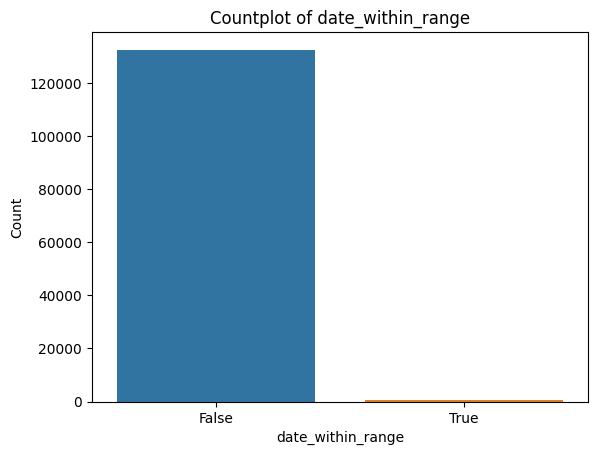

In [ ]:
# Perform the computation and retrieve the result
result = merged_df['date_within_range']

# Create a countplot using seaborn
sns.countplot(x=result.index, data=result)
plt.xlabel('date_within_range')
plt.ylabel('Count')
plt.title('Countplot of date_within_range')
plt.show()